# 数据挖掘作业二：关联规则挖掘

一、本次关联规则挖掘选择的数据集为Wine Reviews，首先对其进行处理，将其转换为适合关联规则挖掘的形式

In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab
import itertools
from collections import defaultdict

处理数据集代码如下：

In [2]:
#读取原始数据集并展示
file_path = "./dataset/wine-reviews/winemag-data-130k-v2.csv"
data = pd.read_csv(file_path)
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [3]:
#对数据集进行转换,并展示
data_transactions=[]
for index, row in data.iterrows():
    data_transactions += [(row['country'], row['variety'], row['winery'])]
data_transactions[:5]

[('Italy', 'White Blend', 'Nicosia'),
 ('Portugal', 'Portuguese Red', 'Quinta dos Avidagos'),
 ('US', 'Pinot Gris', 'Rainstorm'),
 ('US', 'Riesling', 'St. Julian'),
 ('US', 'Pinot Noir', 'Sweet Cheeks')]

二、使用Apriori算法寻找频繁项集，代码如下：

In [4]:
def apriori(data_transactions, minsup=0.1, minconf=0.8, lift=1, minlen=2, maxlen=2):
    item_2_tranidxs = defaultdict(list)
    itemset_2_tranidxs = defaultdict(list)

    for tranidx, tran in enumerate(data_transactions):
        for item in tran:
            item_2_tranidxs[item].append(tranidx)
            itemset_2_tranidxs[frozenset([item])].append(tranidx)

    item_2_tranidxs = dict([(k, frozenset(v)) for k, v in item_2_tranidxs.items()])
    itemset_2_tranidxs = dict([
        (k, frozenset(v)) for k, v in itemset_2_tranidxs.items()])

    tran_count = float(len(data_transactions))
    # print('Extracting rules in {} transactions...'.format(int(tran_count)))

    valid_items = set(item
        for item, tranidxs in item_2_tranidxs.items()
            if (len(tranidxs) / tran_count >= minsup))

    pivot_itemsets = [frozenset([item]) for item in valid_items]
    freqsets = []

    if minlen == 1:
        freqsets.extend(pivot_itemsets)

    for i in range(maxlen - 1):
        new_itemset_size = i + 2
        new_itemsets = []

        for pivot_itemset in pivot_itemsets:
            pivot_tranidxs = itemset_2_tranidxs[pivot_itemset]
            for item, tranidxs in item_2_tranidxs.items():
                if item not in pivot_itemset:
                    common_tranidxs = pivot_tranidxs & tranidxs
                    if len(common_tranidxs) / tran_count >= minsup:
                        new_itemset = frozenset(pivot_itemset | set([item]))
                        if new_itemset not in itemset_2_tranidxs:
                            new_itemsets.append(new_itemset)
                            itemset_2_tranidxs[new_itemset] = common_tranidxs

        if new_itemset_size > minlen - 1:
            freqsets.extend(new_itemsets)

        pivot_itemsets = new_itemsets

    # print('{} frequent patterns found'.format(len(freqsets)))

    for freqset in freqsets:
        for item in freqset:
            rhs = frozenset([item])
            lhs = freqset - rhs
            minsup_rhs = len(itemset_2_tranidxs[rhs]) / tran_count
            if len(lhs) == 0:
                lift_rhs = float(1)
                if minsup_rhs >= minsup and minsup_rhs > minconf and lift_rhs > lift:
                    yield (lhs, rhs, minsup_rhs, minsup_rhs, lift_rhs)
            else:
                minconf_lhs_rhs = len(itemset_2_tranidxs[freqset]) \
                    / float(len(itemset_2_tranidxs[lhs]))
                lift_lhs_rhs = minconf_lhs_rhs / minsup_rhs

                if minconf_lhs_rhs >= minconf and lift_lhs_rhs > lift:
                    minsup_lhs_rhs = len(itemset_2_tranidxs[freqset]) / tran_count
                    yield (lhs, rhs, minsup_lhs_rhs, minconf_lhs_rhs, lift_lhs_rhs)

选择最小支持度阈值minsup>0.05,最小置信度阈值minconf>0.1,得到的频繁项集如下所示：

In [5]:
rules = apriori(data_transactions, minsup=0.05, minconf=0.1, lift=1)
rules_sorted = sorted(rules, key=lambda x: (x[4], x[3], x[2]), reverse=True) # ORDER BY lift DESC, confidence DESC, support DESC
for r in rules_sorted:
    print(r)

(frozenset({'Cabernet Sauvignon'}), frozenset({'US'}), 0.05628178593686284, 0.7722761824324325, 1.841580575864628)
(frozenset({'US'}), frozenset({'Cabernet Sauvignon'}), 0.05628178593686284, 0.13421033318655512, 1.841580575864628)
(frozenset({'Pinot Noir'}), frozenset({'US'}), 0.07605542774926714, 0.7448010849909584, 1.7760630745882846)
(frozenset({'US'}), frozenset({'Pinot Noir'}), 0.07605542774926714, 0.18136283575517392, 1.7760630745882844)
(frozenset({'Chardonnay'}), frozenset({'US'}), 0.052327057574381976, 0.5786607674636263, 1.3798825518863749)
(frozenset({'US'}), frozenset({'Chardonnay'}), 0.052327057574381976, 0.12477983267283135, 1.3798825518863749)


三、根据上述求出的频繁模式导出关联规则，存放于association_rule.csv中，并计算其支持度与置信度。
导出关联规则的代码及所导出关联规则如下所示：

In [6]:
first_col=[]
second_col=[]
third_col=[]
fourth_col=[]
for r in rules_sorted:
    first_col.append(f'{str(list(r[0])[0])} => {str(list(r[1])[0])}')
    second_col.append(r[2])
    third_col.append(r[3])
    fourth_col.append(r[4])
data_rule = {'rule':first_col,'sup':second_col,'conf':third_col,'lift':fourth_col}
pd.DataFrame(data_rule)

,rule,sup,conf,lift
0,Cabernet Sauvignon => US,0.056282,0.772276,1.841581
1,US => Cabernet Sauvignon,0.056282,0.134210,1.841581
2,Pinot Noir => US,0.076055,0.744801,1.776063
3,US => Pinot Noir,0.076055,0.181363,1.776063
4,Chardonnay => US,0.052327,0.578661,1.379883
5,US => Chardonnay,0.052327,0.124780,1.379883


四、导出关联规则后，采用两种指标对其评价，此处选择的指标为Lift，Kulc。Lift在上面的计算中已经给出，下面给出Kulc的计算，并展示

In [7]:
res = []
for r in rules_sorted:
    conf1 = r[3]
    for r2 in rules_sorted:
        if r2[0] == r[1] and r2[1] == r[0]:
            conf2 = r2[3]
    kulc = (conf1 + conf2) / 2
    res.append(kulc)
res

[0.4532432578094938,
 0.4532432578094938,
 0.46308196037306615,
 0.46308196037306615,
 0.3517203000682288,
 0.3517203000682288]

五、对挖掘结果进行分析和可视化展示
分析：根据上述所导出的关联规则及相关支持度、置信度、Lift和Kulc指数，可以看到，由于来自美国的葡萄酒最多，因此关联规则中都是涉及美国的葡萄酒，Cabernet Sauvignon，Pinot Noir，Chardonnay 这三个品种的酒有很大概率是来自与美国。如果你喝的就产自美国，那么是这三个品种的概率较高。
下面进行进行可视化展示，看看这三个品种的酒是否很大部分来自于美国

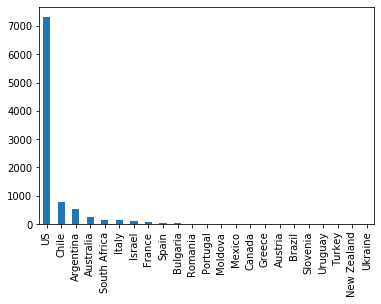

In [8]:
#对Cabernet Sauvignon => US规则可视化
data[data['variety'] == 'Cabernet Sauvignon']['country'].value_counts().plot(kind='bar')

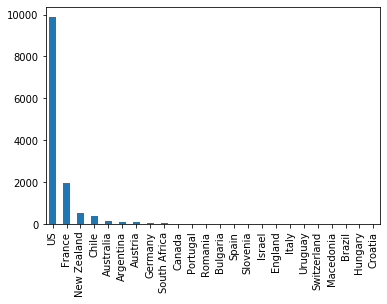

In [9]:
#对Pinot Noir => US规则可视化
data[data['variety'] == 'Pinot Noir']['country'].value_counts().plot(kind='bar')

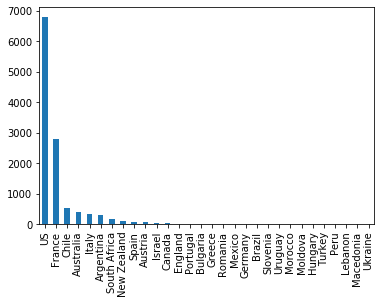

In [10]:
#对Chardonnay => US规则可视化
data[data['variety'] == 'Chardonnay']['country'].value_counts().plot(kind='bar')

通过直方图可视化，可以看到，这三个品种的酒的确很大一部分都是来自于美国，下面再对来自美国的酒做品种可视化分析

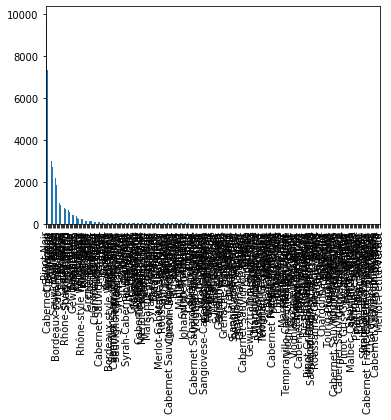

In [11]:
data[data['country'] == 'US']['variety'].value_counts().plot(kind='bar')

可以看到来自美国的酒的品种很多，这三个酒排在前面，是数量较多的品种